<a href="https://colab.research.google.com/github/xup5/Computational-Neuroscience-Class/blob/main/Project%20Option%201%20Neural%20Fitting/Neural_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural fitting

by Xu Pan and Odelia Schwartz, 2022.

As we discussed in the class, convolutional neural networks (CNNs) share a good deal of properties with the visual cortex. A recent trend in research is using different methods to compare CNNs with the visual cortex. One straightforward method is fitting neural responses with CNN activations. More specifically, we give the same stimuli to a CNN and subjects, extract intermediate layer activations as features, then fit features to the neural responses recorded from subjects (see figure below). Once a regression model is trained, we can predict the neural responses to novel stimuli. This method is called voxel-wise encoding model (voxel is a term from fMRI studies. However the same principle can be applied to any other neural data, e.g. EEG, electrophysiology.).

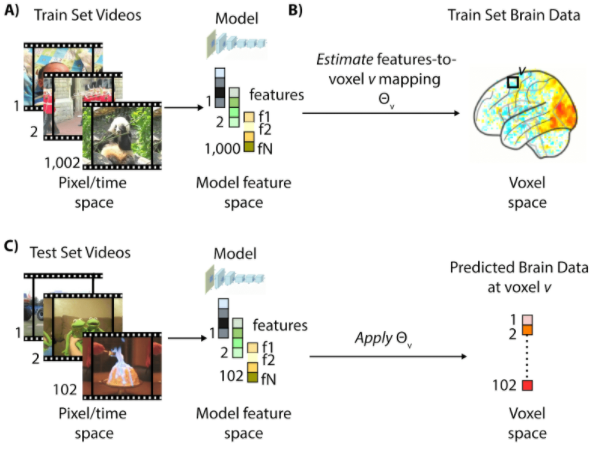

Figure (from ALGONAUTS 2021. They used video stimuli and voxels. In our case, we used images and simulated data.): A) First, given the training set videos, the features of a computational model are extracted. B) A mapping between model features and brain voxels is estimated from the Training Set videos. C) A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.


---

In this project, we provide you with "neural responses" of 5 simulated neurons to 280 images (they are neurons in a artificial neural network, though you should treat them as 5 real neurons or 5 voxels in fMRI recordings). We separated 280 (image, response) pairs into a training set (200 images) and a testing set (80 images).

This project could be considered as a data science problem/competition, and it is also commonly used in computational neuroscience. Basic knowledge about data science and regression models is necessary for this project. You need to train a regression model using some CNN features to predict responses of 5 neurons. **Only training set responses is available to you, and you need to separate it into your own training set and validation set, and ideally with cross-validation.** When you are satisfied with your model, use the model to predict neural responses to 80 test images and submit the predictions to us. We will evaluate your predictions with the hidden test set ground truth, as typical in competitions.

This is a common paradigm for data science competitions. Actually we structured it based on a real competition, i.g. THE ALGONAUTS PROJECT. However, we don't really grade your final project based on your prediction performance, neither this is a true competition...

---

A simple tutorial is attached below. And here are some tips that may help you design your regression model.


1.   Use **VGG16** features. However, you are free to explore other CNNs features.
2.   You can use traditional regression methods, such as **Lasso regression and Ridge regression**. Try different **alpha** values. Scikit-learn package is very useful. Alternatively, you can train a **neural network regressor**.
3.   You can **use one layer at a time as your features**, and you can explore which layer is the best. For example, in the tutorial, I use activations in "block2_conv1" as my feature.
4.   Because of the limited data and the high dimensionality of features, It is good to do a **spatial pooling** before using the features. There are different ways to do pooling, e.g. max pooling and average pooling, and you can try different pool sizes. Try to explore these hyperparameters. They are important to good regression performance.
5.   **Cross-validate** your model, i.e. split train-validation sets multiple times. Scikit-learn has built-in functions for cross-validation.
6.   You will have an over-fitting problem. It is very hard to avoid it when dealing with high-dimentional data. As long as you are doing cross-validation, you can trust your averaged validation score.

7.   0.15 is a ok score. 0.3 is a very good score. Some neurons are more difficult to fit. You may want to fit different neurons with different regression models to gain better overall fitness.

---

Relevant references:

1.   THE ALGONAUTS PROJECT http://algonauts.csail.mit.edu/encoding.html

2.   Naselaris, T., Kay, K. N., Nishimoto, S., & Gallant, J. L. (2011). Encoding and decoding in fMRI. Neuroimage, 56(2), 400-410.

3.   Cadena, Santiago A., et al. "Deep convolutional models improve predictions of macaque V1 responses to natural images." PLoS computational biology 15.4 (2019): e1006897.

4.   Kindel, William F., Elijah D. Christensen, and Joel Zylberberg. "Using deep learning to probe the neural code for images in primary visual cortex." Journal of vision 19.4 (2019): 29-29.

5.   Brain-Score https://www.brain-score.org/


## 1. Get dataset

In [1]:
# git clone our course repository. It has images and responses files.

! git clone https://github.com/schwartz-cnl/Computational-Neuroscience-Class

# Images are in "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"
# and "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
#
# "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy"
# and "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_test.npy"
# contains simulated neural responses to the image stimuli.

Cloning into 'Computational-Neuroscience-Class'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (522/522), done.
remote: Compressing objects: 100% (501/501), done.
remote: Total 522 (delta 94), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (522/522), 42.94 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [2]:
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import numpy as np

# load neural responses. It is a np array with shape (200, 5) which corresponds
# to 200 images and 5 neurons.
neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")


# Code below is for loading and preprocessing images.
# Images will be loaded in train_iterator and test_iterator, which are two lists.
# elements in the list are np arrays with shape (10,224,224,3). 10 is batch size.
# Images are 224x224 with 3 color channels.
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
test_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"

batch_size = 10
img_height = 224
img_width = 224

trainfiles = [join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
trainfiles = sorted(trainfiles)

testfiles = [join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))]
testfiles = sorted(testfiles)

def load_image(im_file):
  image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  image = tf.keras.applications.vgg16.preprocess_input(image)
  return image

train_dataset = tf.data.Dataset.from_tensor_slices(trainfiles)
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.batch(10)
train_iterator = list(train_dataset.as_numpy_iterator())

test_dataset = tf.data.Dataset.from_tensor_slices(testfiles)
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(10)
test_iterator = list(test_dataset.as_numpy_iterator())

## Load VGG16 model and get features

In [3]:
# Load a pretrained VGG16 model.
# use summary() to print the structure of the network.
# Layer names, such as "block1_conv2", is what you need for the next section to 
# get intermediate layer activations.
model = tf.keras.applications.vgg16.VGG16()
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [40]:
# build a partial model to get intermediate layer activations. You need to 
# explore different layers.
partial_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("block2_conv1").output)

# Now input images to the partial model to getintermediate layer activations (features).
train_feature = []
for image_batch in train_iterator:
  activation = partial_model(image_batch,training=False)
  # Note that, here I used a max pooling to reduce spatial size. You may need 
  # to change ksize and strides.
  activation = tf.nn.max_pool2d(activation, ksize=(3, 3), strides=(3, 3),padding="SAME")
  train_feature.append(activation.numpy())
train_feature = np.concatenate(train_feature, axis=0)
# train_feature is a np array with shape (200, xxx). xxx is the number of features.
train_feature = np.reshape(train_feature,(200,-1))

test_feature = []
for image_batch in test_iterator:
  activation = partial_model(image_batch,training=False)
  activation = tf.nn.max_pool2d(activation, ksize=(14, 14), strides=(14, 14),padding="SAME")
  test_feature.append(activation.numpy())
test_feature = np.concatenate(test_feature, axis=0)
test_feature = np.reshape(test_feature,(80,-1))

In [41]:
# check the shape of features and targets.
print(train_feature.shape)
print(test_feature.shape)
print(neural_response_train.shape)

(200, 184832)
(80, 8192)
(200, 5)


## Build a regression model

In [42]:
from sklearn.model_selection import train_test_split

# Split training set into a new training set and a validation set.
# I don't do cross-validation in this tutorial, but you should do it...
X_train, X_val, y_train, y_val = train_test_split(train_feature, neural_response_train, test_size=0.3)

In [43]:
from sklearn import linear_model
import scipy

# Define a regression model. Here I use Lasso. It is better if you normalize
# the feature first. You can use the "pipeline" class provided by sklearn to pack 
# multiple steps into one model (you can even have PCA in the pipeline which 
# is worth a try).
clf = linear_model.Lasso(alpha=50)
# clf = linear_model.Ridge(alpha=100)

# Now train the model
clf.fit(X_train, y_train)

# We use Pearson correlation to evaluate the fitness. This "score" function
# returns Pearson correlation.
def score(prediction, truevalue):
  return scipy.stats.pearsonr(prediction, truevalue)[0]

# We have 5 neurons. Let's look at the train and validation score for each of
# them
for n in range(5):
  train_score = score(clf.predict(X_train)[:,n], y_train[:,n])
  val_score = score(clf.predict(X_val)[:,n], y_val[:,n])
  print("neuron {}, train score = {}, validation score = {}".format(n, train_score, val_score))

neuron 0, train score = 0.8407325129864427, validation score = 0.1742409387556355
neuron 1, train score = 0.5983525519888517, validation score = 0.05792469771289202
neuron 2, train score = 0.86649454324521, validation score = 0.04700143554549982
neuron 3, train score = 0.8734746267543793, validation score = -0.03857351673498165
neuron 4, train score = 0.8558901966368351, validation score = 0.32045838095636736


It seems some neurons have good scores, some don't...

## Your turn

Now it is your turn to play with different settings (regressor, hyperparameters, feature selection, etc). And don't forget to use your best model(s) to predict the test images, export predictions into a npy file and send it us (you can download files from colab by clicking the "folder" icon on the left tool bar).

When writing your report, include what settings you explored. It would be good if you have plots, for example, some hyperparameters or layer number on the x-axis, score on the y-axis.